# MSDS 422 Final Project: Movie Recommendation Systems

***Authors: Shruti, Rukun, Niranchana, Sumit*** <br>
***Date: 2023-08-24***

## 1.1 Problem Statement/Research objective(s)

### Problem Background
- In today's digital age, streaming platforms offer a vast library of movies to users. 
- However, with the sheer volume of available content, users often struggle to discover movies that match their interests. 
- A movie recommendation system aims to solve this problem by leveraging user behavior and preferences to provide personalized movie suggestions, enhancing user experience and engagement.

### Objective
The goal of this project is to design and develop an efficient and accurate movie recommendation system that can intelligently suggest movies to users based on their past viewing history, ratings, and the behavior of similar users.

### Scope

As a part of this project, we shall be building recommendations using the following algorithms,
- Overall movie recommendation based on popularity and genre
- Content based recommendation
- Collaboration based movie recommendation

## 1.2 Recommendation Algorithm Overview

**Overall Movie recommendations**
- This is a Simple Recommender, which offers generalized recommendations to every user based on movie popularity and genre. 
- The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. 
- This model does not give personalized recommendations based on the user.

**Content Based Movie Recommendation**
- A Content-Based Recommendation System suggests movies to users based on their intrinsic attributes such as genres, actors, and plot details. 
- It personalizes recommendations by matching item content to user preferences
- This is achieved by building an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked.

**Collaborative Filtering Based Movie Recommendation**
- Collaborative Filtering is a recommendation technique that identifies user preferences by analyzing interactions and behaviors of similar users. 
- Collaborative Filtering is based on the idea that users similar to a user A,  can be used to predict how much user A will like a particular movie, based on their likings and reviews
- This approach offers personalized suggestions and is effective for both known and unknown items

In [1]:
## Installing required Libraries

# linear algebra
import numpy as np 

# data processing
import pandas as pd 
from sklearn.model_selection import train_test_split
import operator
from sklearn.preprocessing import StandardScaler
import time

# ML Libraries
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # Auto-adjust width

# Set the display option to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1.3 DataSet Overview and Pre-processing

Source: [Movie Recommender Systems - Kaggle](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings_small.csv)

The Full Dataset: Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags. <br>


The Small Dataset: Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users. <br>

These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

Content
This dataset consists of the following files:

**movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

**keywords.csv**: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

**credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

**links.csv**: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

**links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

**ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.

The Full MovieLens Dataset consisting of 26 million ratings and 750,000 tag applications from 270,000 users on all the 45,000 movies in this dataset

**Acknowledgements**

- This dataset is an ensemble of data collected from TMDB and GroupLens.
- The Movie Details, Credits and Keywords have been collected from the TMDB Open API. This product uses the TMDb API but is not endorsed or certified by TMDb. Their API also provides access to data on many additional movies, actors and actresses, crew members, and TV shows. The API documentation is [here](https://developer.themoviedb.org/docs)
- The Movie Links and Ratings have been obtained from the Official GroupLens website. The files are a part of the dataset available [here](https://grouplens.org/datasets/movielens/latest/)

### 1.3.1 Loading Required Data

In [18]:
md = pd.read_csv('movies_metadata.csv')
md.info()
md.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.95,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.00,81.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.70,5415.00
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.02,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.00,104.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.90,2413.00
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.71,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.00,101.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.50,92.00
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.86,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.00,127.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.10,34.00
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.39,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.00,106.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.70,173.00


### 3.1.2 Data Pre-processing

**Formating the fields to extract Genre in a different field**

In [17]:
# Extracting Genres in a new column

md.rename(columns={'genres': 'genres_full'}, inplace=True)
md['genres'] = md['genres_full'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] 
                                                                   if isinstance(x, list) else [])

ValueError: invalid literal for int() with base 10: '1997-08-20'

**Removing abnormal data**

In [22]:
# We see some of the id values are date values. We can remove these records from the data
md[md['id'].str.contains('-')]

# Delete records with '-'
mask = md['id'].str.contains('-')
md = md[~mask]

,adult,belongs_to_collection,budget,genres_full,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres


,adult,belongs_to_collection,budget,genres_full,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres


**Function for basic data cleaning**

We can make use of libraries like pandas for working with data frames and NLTK for natural language processing tasks such as lowercasing, tokenization, removing stop words, and stemming. <br>

Further we shall be using the data pre-processing as needed in the algorithms<br>

Not all the algorithms need data pre-processing, especially the once where only ratings are used for calculating some of the top recommended movies, we would not need pre-processing on the text data. Live Simple Overall Recommendation algorithm using IMDBs weighted ratings for recommendations. <br>

But we would need data cleaning for Content based recommendation, which calculates distance based on text data, as well as for Collaborating filtering as well where we would need to tokenize the data

In [ ]:
def clean_text_column(df, column_name):
    # Initialize NLTK's Porter Stemmer and download stopwords
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    
    # Define a function to perform text cleaning steps
    def clean_text(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and punctuations
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        
        # Remove email addresses
        text = re.sub(r"\S+@\S+", "", text)
        
        # Tokenize the text
        words = word_tokenize(text)
        
        # Remove stop words and perform stemming
        words = [stemmer.stem(word) for word in words if word not in stop_words]
        
        # Join the cleaned words back into a sentence
        cleaned_text = " ".join(words)
        
        return cleaned_text
    
    # Apply the clean_text function to the specified column
    df[column_name] = df[column_name].apply(clean_text)
    
    return df

## 1.4. Simple Recommender

The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

**Intuition**
- To offers generalized recommendations to every user based on movie popularity & ratings, by some features like genre. 
- The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. 
- This model does not give personalized recommendations based on the user.

**Objective**
- To sort movies based on ratings and popularity and display the top movies of our list. 
- As an added step, we can pass in a genre argument to get the top movies of a particular genre.

**Methodology**
- Step 1: Using IMDB's weighted rating formula, as a weighted score to identify top Movies
    - v is the number of votes for the movie
    - m is the minimum votes required to be listed in the chart (Using 95th percentile on the number of votes)
    - R is the average rating of the movie
    - C is the mean vote across the whole report
- Step 2: Filtering only the eligible movies based on the above criteria’s
- Step 3: Providing top movies overall
- Step 4: Additionally, created a function to identify top movies within each Genre.

### Using IMDB Weighted Rating Formala (Using TMDB ratings)

As a simple recommender providing general recommendations (not personalized to a user), we can leverage IMDB's weighted ratings to recommend top movies based on the TMDB ratings

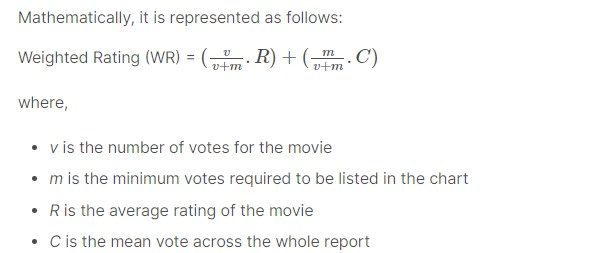

For **m** (Minimum votes needed to be listed), We will use **95th percentile** as our cutoff
-  For a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list

In [4]:
## Converting votecounts to integer

vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')

In [4]:
# Identifying year from release date
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] 
                                                                       if x != np.nan else np.nan)

In [21]:
md.head(1)

,adult,belongs_to_collection,budget,genres_full,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.95,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.00,81.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.70,5415.00,"[Animation, Comedy, Family]",1995


In [5]:
C = vote_averages.mean()
m = vote_counts.quantile(0.95)

print("C: ", C)
print("m: ", m)

C:  5.244896612406511
m:  434.0


**Filtering for only qualitied movies**
- A movie has to have at least 434 votes on TMDB. 
- We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10.

In [6]:
qualified = md[(md['vote_count'] >= m) & 
               (md['vote_count'].notnull()) & 
               (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]

qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')

qualified.shape

(2274, 6)

*2274 Movies qualify to be on our chart*

### 1.4.1 Top Overall Movies
These are overall top movies

In [7]:
# Function Definition

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

qualified['wr'] = qualified.apply(weighted_rating, axis=1)

qualified = qualified.sort_values('wr', ascending=False).head(250)

In [24]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.11,"[Action, Thriller, Science Fiction, Mystery, A...",7.92
12481,The Dark Knight,2008,12269,8,123.17,"[Drama, Action, Crime, Thriller]",7.91
22879,Interstellar,2014,11187,8,32.21,"[Adventure, Drama, Science Fiction]",7.90
2843,Fight Club,1999,9678,8,63.87,[Drama],7.88
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.07,"[Adventure, Fantasy, Action]",7.87
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.87
314,The Shawshank Redemption,1994,8358,8,51.65,"[Drama, Crime]",7.86
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.32,"[Adventure, Fantasy, Action]",7.86
351,Forrest Gump,1994,8147,8,48.31,"[Comedy, Drama, Romance]",7.86
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.42,"[Adventure, Fantasy, Action]",7.85


We see that three Christopher Nolan Films, Inception, The Dark Knight and Interstellar occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors.

### 4.1.2 Top Movies Based on Genre

Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the 85th percentile instead of 95, since this is Genre based and we might not find enough movies with high thresholds

In [8]:
# Convert data at movie-genre level

s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [26]:
gen_md.info()
gen_md.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93548 entries, 0 to 45465
Data columns (total 26 columns):
adult                    93548 non-null object
belongs_to_collection    11162 non-null object
budget                   93548 non-null object
genres_full              93548 non-null object
homepage                 16556 non-null object
id                       93548 non-null object
imdb_id                  93513 non-null object
original_language        93531 non-null object
original_title           93548 non-null object
overview                 92218 non-null object
popularity               93531 non-null object
poster_path              93083 non-null object
production_companies     93539 non-null object
production_countries     93539 non-null object
release_date             93432 non-null object
revenue                  93527 non-null float64
runtime                  93194 non-null float64
spoken_languages         93527 non-null object
status                   93402 non-null obj

,adult,belongs_to_collection,budget,genres_full,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.95,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.00,81.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.70,5415.00,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.95,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.00,81.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.70,5415.00,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.95,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.00,81.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.70,5415.00,1995,Family
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.02,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.00,104.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.90,2413.00,1995,Adventure
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.02,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.00,104.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.90,2413.00,1995,Fantasy


In [27]:
# Function to identifying top movies by Genres

def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [28]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.46,8.57
351,Forrest Gump,1994,8147,8,48.31,7.97
876,Vertigo,1958,1162,8,18.21,7.81
40251,Your Name.,2016,1030,8,34.461252,7.79
883,Some Like It Hot,1959,835,8,11.85,7.75
1132,Cinema Paradiso,1988,834,8,14.18,7.74
19901,Paperman,2012,734,8,7.20,7.71
37863,Sing Street,2016,669,8,10.672862,7.69
882,The Apartment,1960,498,8,11.99,7.60
38718,The Handmaiden,2016,453,8,16.727405,7.57


**Limitations of Overall Movie Recommendation**

- Limited Personalization: IMDB weighted ratings focus on a general audience's perspective and don't take into account individual preferences, viewing history, or context. This can result in recommendations that may not align with a user's unique tastes and interests.
- Genre Oversimplification: The IMDB formula applied within each genre assumes that all movies within a genre should be ranked similarly, ignoring the diversity and nuances within genres. It overlooks the fact that users might have preferences for specific sub-genres, themes, or styles.
- New and Unrated Movies: Emerging movies with potential might be overlooked because they lack sufficient ratings or historical data. This limits the ability to recommend newer, lesser-known, or indie films.
- Biased Popularity: The IMDB formula tends to favor popular and widely-known movies, potentially excluding hidden gems that may have smaller but dedicated fan bases.
- Cultural and Regional Differences: The formula does not account for the fact that user preferences can vary based on cultural backgrounds, regional trends, and language preferences.
- No Personal Context: IMDB ratings do not consider a user's watching history, past ratings, or demographic information. Recommendations based on such context can lead to more relevant and engaging suggestions.

## 1.5. Content Based Recommender

The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 15 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.

For instance, consider a person who loves Dilwale Dulhania Le Jayenge, My Name is Khan and Kabhi Khushi Kabhi Gham. One inference we can obtain is that the person loves the actor Shahrukh Khan and the director Karan Johar. Even if s/he were to access the romance chart, s/he wouldn't find these as the top recommendations.

To personalise our recommendations more, we will build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as Content Based Filtering.

**Intuition**
- This method generates content based on user profile and preferences.
- Content-based filtering is based on the idea that users will be interested in items that are similar to those they’ve liked or interacted with in the past. It analyzes the features of items and the preferences of users to make recommendations by finding items that are similar  to the user’s past interactions.

**Objective**
- To build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked.
- As a part of this assignment, we built our recommendations on, 
    - Movie Overviews and Taglines
    - Movie Cast, Crew, Keywords and Genre
    
**Methodology**
- Step 1: Collect key features representing user’s preferences,
    - Movie Overview, tagline, Movie Cast – Director; Actor, Crew, Keywords and Genre
- Step 2: Tokenize the users preference 
- Step 3: Compute similarity scores between item features and user profiles using measures like cosine similarity.
    - Movies that share similar attributes with the user's preferred movies receive higher similarity scores.  
- Step 4: Build function to generate lists of movies with the highest similarity scores based on user preference

### 1.5.1 Movie Description Based Recommender

In [9]:
smd = md.copy()

In [10]:
# Combining Movie tagline and overview get the movie description

smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [32]:
# Creating a term Document matrix to 

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [11]:
from sklearn.externals import joblib

# Save tfidf_matrix
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')

In [12]:
# Reading the data from the pkl file

# Load tfidf_matrix
tfidf_matrix = joblib.load('tfidf_matrix.pkl')

In [13]:
tfidf_matrix.shape

(45466, 1104495)

We will be using **Cosine Similarity** to calcuate the similarity (distance) between them**

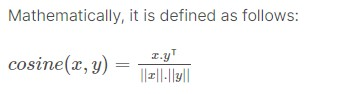

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [43]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [38]:
cosine_sim[0]

array([1.        , 0.00511815, 0.        , ..., 0.        , 0.00236866,
       0.        ])

In [44]:
# Save cosine similarity matrix
joblib.dump(cosine_sim, 'cosine_sim.pkl')

['cosine_sim.pkl']

In [14]:
# Load cosine similarity matrix
cosine_sim = joblib.load('cosine_sim.pkl')

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [15]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [44]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]  # Convert to list

In [59]:
get_recommendations('Dilwale Dulhania Le Jayenge').head(10)

36527               Dhund: The Fog
36869                     Gangster
36204                      Yaadein
36356                      Humraaz
16433         Mujhse Dosti Karoge!
30283            I Hate Luv Storys
15020                Chalte Chalte
34421                  Kurukshetra
34427    Har Dil Jo Pyar Karega...
42060      Buddha in a Traffic Jam
Name: title, dtype: object

In [60]:
get_recommendations('Avatar').head(10)

28645                          Stand by Me Doraemon
16068                                 Bloodbrothers
18002                         The War of the Robots
2458                                     The Matrix
29992                                     Shakedown
6415     Lara Croft Tomb Raider: The Cradle of Life
13887                          The Inhabited Island
3535                Pandora and the Flying Dutchman
6075                               Tears of the Sun
23630                                Beware of Pity
Name: title, dtype: object

In [58]:
get_recommendations('The Godfather').head(10)

44030    The Godfather Trilogy: 1972-1990
1178               The Godfather: Part II
31973                    Honor Thy Father
21614                          The Family
23126                          Blood Ties
38030            A Mother Should Be Loved
18322                     The Outside Man
11297                    Household Saints
10821                            Election
4324                                 Made
Name: title, dtype: object

We see that for The Godfather, our system is able to identify its subsequent films. It also adds in other movies related to father, probably from the description. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie.

Therefore, we are going to use much more suggestive metadata than Overview and Tagline. In the next subsection, we will build a more sophisticated recommender that takes genre, keywords, cast and crew into consideration.

### 1.5.2 Movie Cast, Crew, Keywords and Genre Based Recommender (Metadata Based)

To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [23]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [24]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')

In [25]:
md['id'] = md['id'].astype('int')
md.shape

(45463, 25)

In [26]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [27]:
md.head(1)

,adult,belongs_to_collection,budget,genres_full,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.95,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.00,81.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.70,5415.00,"[Animation, Comedy, Family]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."


We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

- **Crew**: From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.
- **Cast**: Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [28]:
smd = md.copy()
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [29]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [30]:
smd['director'] = smd['crew'].apply(get_director)

In [31]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [32]:
smd.head(1)

,adult,belongs_to_collection,budget,genres_full,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.95,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.00,81.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.70,5415.00,"[Animation, Comedy, Family]","[Tom Hanks, Tim Allen, Don Rickles]","[{'department': 'Directing', 'job': 'Director'...","[jealousy, toy, boy, friendship, friends, riva...",13,106,John Lasseter


We will use a **Count Vectorizer** to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of my genres and credits data:

- Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.
- Mention Director 3 times to give it more weight relative to the entire cast.

In [33]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [34]:
# Processig Keywords

s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()

In [35]:
s[:5]

woman director      3128
independent film    1942
murder              1314
based on novel       841
musical              734
Name: keyword, dtype: int64

In [36]:
s = s[s > 1]

In [37]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [38]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [39]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [40]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [41]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [42]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [43]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [46]:
get_recommendations('Avatar').head(10)

26774                          Avatar 2
9741                 Aliens of the Deep
45149        T2 3-D: Battle Across Time
1179                             Aliens
6220                Ghosts of the Abyss
1216                     The Terminator
582          Terminator 2: Judgment Day
1113                          The Abyss
5696     Piranha Part Two: The Spawning
375                           True Lies
Name: title, dtype: object

In [47]:
get_recommendations('Dilwale Dulhania Le Jayenge').head(10)

13299                                  Rab Ne Bana Di Jodi
14986                                         Love Stories
14409                                                 Fame
14498                             Under the Roofs of Paris
15063                                      My Name Is Khan
12322                                         Om Shanti Om
6639                                          Hard to Hold
7434                                                  Girl
11091    Marilyn Hotchkiss' Ballroom Dancing & Charm Sc...
1488                                       Shall We Dance?
Name: title, dtype: object

In [49]:
get_recommendations('Harry Potter and the Goblet of Fire').head(10)

6104                                 Into the West
15436          Prince of Persia: The Sands of Time
12036    Harry Potter and the Order of the Phoenix
5733       Harry Potter and the Chamber of Secrets
33749                              The Good Father
7801      Harry Potter and the Prisoner of Azkaban
31265                     The Man in the Iron Mask
22185                           Great Expectations
2504                                   Pushing Tin
3979                       Amazing Grace and Chuck
Name: title, dtype: object

**Scope of Improvement**
- We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

## 1.6 Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

I will not be implementing Collaborative Filtering from scratch. Instead, I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [2]:
reader = Reader()

In [12]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


In [4]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**Exploring the data below**

In [5]:
len(ratings['movieId'].unique()) # We have 9066 movies

9724

In [6]:
# lets see the number of views rated by user 1

len(ratings[ratings['userId'] == 1]['movieId'].unique()) # User 1 has rated 232 movies
len(ratings[ratings['userId'] == 2]['movieId'].unique()) # User 2 has rated 29 movies
len(ratings[ratings['userId'] == 3]['movieId'].unique()) # User 3 has rated 39 movies

# ratings[ratings['userId'] == 1].sort_values('rating', ascending = False)

232

29

39

In [7]:
# Group the ratings DataFrame by 'userId' and count the unique 'movieId' values
user_movie_counts = ratings.groupby('userId')['movieId'].nunique()

# Create a new DataFrame from the groupby result
user_movie_counts_df = pd.DataFrame({'userId': user_movie_counts.index, 'movies_rated': user_movie_counts.values})

In [8]:
# Top users with the most movie ratings
user_movie_counts_df.sort_values('movies_rated', ascending = False).head()

# Top users with the least movie ratings
user_movie_counts_df.sort_values('movies_rated', ascending = True).head() # minimum movies rated by the users is 20

,movies_rated,userId
413,2698,414
598,2478,599
473,2108,474
447,1864,448
273,1346,274


,movies_rated,userId
441,20,442
405,20,406
146,20,147
193,20,194
568,20,569


**Preparing a dataset with movie ids added in ratings table**

In [9]:
ratings_with_movieid = ratings.merge(movies, left_on='movieId', right_on='movieId', how='inner')

In [10]:
# Looking at the movies rated by user 2

ratings_with_movieid[ratings_with_movieid['userId'] == 2].sort_values('rating', ascending = False)

,userId,movieId,rating,timestamp,title,genres
18091,2,131724,5.00,1445714851,The Jinx: The Life and Deaths of Robert Durst ...,Documentary
18044,2,122882,5.00,1445715272,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller
17848,2,106782,5.00,1445714966,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
17648,2,89774,5.00,1445715189,Warrior (2011),Drama
17213,2,60756,5.00,1445714980,Step Brothers (2008),Comedy
17627,2,80906,5.00,1445715172,Inside Job (2010),Documentary
16613,2,1704,4.50,1445715228,Good Will Hunting (1997),Drama|Romance
17064,2,58559,4.50,1445715141,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
17241,2,68157,4.50,1445715154,Inglourious Basterds (2009),Action|Drama|War
17605,2,80489,4.50,1445715340,"Town, The (2010)",Crime|Drama|Thriller


### 1.6.1 Implementing Collaborative filtering using SVD

In [11]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [12]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8778
MAE:  0.6733
------------
Fold 2
RMSE: 0.8743
MAE:  0.6711
------------
Fold 3
RMSE: 0.8671
MAE:  0.6661
------------
Fold 4
RMSE: 0.8799
MAE:  0.6763
------------
Fold 5
RMSE: 0.8665
MAE:  0.6660
------------
------------
Mean RMSE: 0.8731
Mean MAE : 0.6705
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.6732583799876344,
                             0.6710507638412715,
                             0.6661002572468603,
                             0.6763098120645935,
                             0.6659604869578369],
                            'rmse': [0.8777923671778229,
                             0.8743275990789853,
                             0.8670500096530719,
                             0.879922812371005,
                             0.866484005925248]})

In [13]:
# Training on complete data

trainset = data.build_full_trainset()
svd.train(trainset)

In [14]:
# Checking the prediction given to the user

svd.predict(2, 333) # userid = 2; movieid = 333

Prediction(uid=2, iid=333, r_ui=None, est=3.78239731406319, details={'was_impossible': False})

In [15]:
# Iterating over the complete dataset

predicted_ratings = []
for index, row in ratings_with_movieid.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    predicted_rating = svd.predict(user_id, movie_id).est
    predicted_ratings.append(predicted_rating)
    
# Add the predicted ratings column to the DataFrame
ratings_with_movieid['predicted_rating'] = predicted_ratings

In [16]:
ratings_with_movieid.head()

,userId,movieId,rating,timestamp,title,genres,predicted_rating
0,1,1,4.00,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.39
1,5,1,4.00,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.79
2,7,1,4.50,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.93
3,15,1,2.50,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.27
4,17,1,4.50,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.25


In [17]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(ratings_with_movieid['rating'], ratings_with_movieid['predicted_rating']))

print("Root Mean Squared Error (RMSE): ",rmse)

Root Mean Squared Error (RMSE):  0.6266338588040341


#### Improvised SVD model

In [73]:
from surprise.model_selection import cross_validate

# Create a Surprise Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the data into train and test sets for final RMSE calculation
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize the SVD model with regularization and other hyperparameters
svd2 = SVD(n_factors=100, reg_all=0.02, lr_all=0.005, random_state=42)

# Perform 5-fold cross-validation
results = cross_validate(svd2, trainset, measures=['RMSE'], cv=5, verbose=True)

# Print the RMSE scores for each fold
print("Cross-validation RMSE scores:")
for fold, rmse in enumerate(results['test_rmse'], start=1):
    print("Fold {fold}: ",rmse)

# Calculate and print the average RMSE across all folds
average_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
print("Average RMSE across all folds: ", average_rmse)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8748  0.8739  0.8730  0.8719  0.8797  0.8746  0.0027  
Fit time          3.87    3.84    3.96    3.73    3.88    3.86    0.07    
Test time         0.14    0.31    0.15    0.16    0.32    0.22    0.08    
Cross-validation RMSE scores:
Fold {fold}:  0.8747926373204726
Fold {fold}:  0.8738526275230449
Fold {fold}:  0.8729971010596242
Fold {fold}:  0.871859877002868
Fold {fold}:  0.879709067896361
Average RMSE across all folds:  0.8746422621604744


In [20]:
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
import pandas as pd

# Load the ratings DataFrame (replace with your data loading code)
# Assuming you have columns 'userId', 'movieId', and 'rating'
ratings = pd.read_csv('ratings.csv')

# Create a Surprise Dataset
from surprise import Dataset, Reader
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Initialize the SVD model with regularization and other hyperparameters
svd = SVD(n_factors=100, reg_all=0.02, lr_all=0.005, random_state=42)

# Perform 5-fold cross-validation on the dataset
results = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

# Print the RMSE scores for each fold
print("Cross-validation RMSE scores:")
for fold, rmse in enumerate(results['test_rmse'], start=1):
    print("Fold {}: {:.4f}".format(fold, rmse))

# Calculate and print the average RMSE across all folds
average_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
print("Average RMSE across all folds: {:.4f}".format(average_rmse))

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8788  0.8704  0.8715  0.8708  0.8687  0.8720  0.0035  
Fit time          3.77    3.78    3.71    3.71    3.72    3.74    0.03    
Test time         0.32    0.13    0.13    0.32    0.13    0.21    0.09    
Cross-validation RMSE scores:
Fold 1: 0.8788
Fold 2: 0.8704
Fold 3: 0.8715
Fold 4: 0.8708
Fold 5: 0.8687
Average RMSE across all folds: 0.8720


In [21]:
# Train the SVD model on the full trainset
svd.fit(trainset)

# Make predictions on the test set
predictions = svd.test(testset)

# Calculate RMSE for the test predictions
rmse = accuracy.rmse(predictions)
print("Final Test RMSE: {:.4f}".format(rmse))

RMSE: 0.8807
Final Test RMSE: 0.8807


In [92]:
def get_top_n_recommendations(user_id, model, movies_df, n, unseen_ratings=None):
    # Load the ratings DataFrame (replace with your data loading code)
    # Assuming you have columns 'userId', 'movieId', and 'rating'

    # Get all unique movie IDs
    all_movie_ids = ratings['movieId'].unique()

    # Convert all_movie_ids to a pandas Series
    all_movie_ids_series = pd.Series(all_movie_ids)

    # Create a DataFrame to store predicted ratings for the user
    predicted_ratings_df = pd.DataFrame(index=all_movie_ids_series, columns=[user_id])

    # Fill in the predicted ratings for the user using the provided model
    for movie_id in all_movie_ids_series:
        predicted_rating = model.predict(user_id, movie_id).est
        predicted_ratings_df.loc[movie_id, user_id] = predicted_rating

    # If unseen_ratings is 1, consider only movies without user's ratings
    if unseen_ratings == 1:
        print("In the unseen_ratings")
        
        # Get movie IDs rated by the user
        user_rated_movie_ids = ratings[ratings['userId'] == user_id]['movieId'].values 
        
        # Get unrated movie IDs
        unrated_movie_ids = all_movie_ids_series[~all_movie_ids_series.isin(user_rated_movie_ids)]
          
        # Filter the predicted ratings DataFrame to include only unrated movies
        unrated_predicted_ratings_df = predicted_ratings_df.loc[unrated_movie_ids]
        
        # Get top N recommendations for unrated movies
        top_n_recommendations = unrated_predicted_ratings_df.sort_values(ascending=False, by = user_id)[user_id].head(n)
        
    else:
        top_n_recommendations = predicted_ratings_df[user_id].sort_values(ascending=False).head(n)

    # Create a DataFrame with movieId and predicted_rating columns
    top_n_df = pd.DataFrame({'movieId': top_n_recommendations.index, 'predicted_rating': top_n_recommendations.values})

    # Merge with movies DataFrame to get movie names
    top_n_recommendations_with_names = pd.merge(top_n_df, movies_df, on='movieId')
    
    return top_n_recommendations_with_names[['movieId', 'title', 'predicted_rating']]



In [93]:
get_top_n_recommendations(1, svd, movies, n = 10, unseen_ratings = 0)

,movieId,title,predicted_rating
0,6711,Lost in Translation (2003),5
1,1104,"Streetcar Named Desire, A (1951)",5
2,1222,Full Metal Jacket (1987),5
3,2019,Seven Samurai (Shichinin no samurai) (1954),5
4,1223,"Grand Day Out with Wallace and Gromit, A (1989)",5
5,48516,"Departed, The (2006)",5
6,741,Ghost in the Shell (Kôkaku kidôtai) (1995),5
7,1233,"Boot, Das (Boat, The) (1981)",5
8,2571,"Matrix, The (1999)",5
9,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),5


In [94]:
get_top_n_recommendations(1, svd, movies, n = 10, unseen_ratings = 1)

In the unseen_ratings


,movieId,title,predicted_rating
0,750,Dr. Strangelove or: How I Learned to Stop Worr...,5
1,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),5
2,1223,"Grand Day Out with Wallace and Gromit, A (1989)",5
3,1104,"Streetcar Named Desire, A (1951)",5
4,6711,Lost in Translation (2003),5
5,2019,Seven Samurai (Shichinin no samurai) (1954),5
6,1204,Lawrence of Arabia (1962),5
7,7153,"Lord of the Rings: The Return of the King, The...",5
8,1193,One Flew Over the Cuckoo's Nest (1975),5
9,541,Blade Runner (1982),5


### 1.6.2 Implementing Collaborative Filtering using Deep Neural Networks (using Keras)

In [15]:
df = ratings.copy()

user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


**Preparing Training & Validation Data**

In [16]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

**Create the model**

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [18]:
import keras
from keras import layers
import tensorflow as tf

In [26]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

    
# Define a custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
# model.compile(
#     loss=keras.losses.BinaryCrossentropy(),
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
# )

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', rmse]
)

In [27]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 22s 14ms/step - loss: 0.6373 - accuracy: 0.1266 - rmse: 0.2314 - val_loss: 0.6208 - val_accuracy: 0.1293 - val_rmse: 0.2140
Epoch 2/5
1418/1418 [==============================] - 20s 14ms/step - loss: 0.6132 - accuracy: 0.1331 - rmse: 0.2069 - val_loss: 0.6208 - val_accuracy: 0.1319 - val_rmse: 0.2138
Epoch 3/5
1418/1418 [==============================] - 20s 14ms/step - loss: 0.6089 - accuracy: 0.1343 - rmse: 0.2021 - val_loss: 0.6132 - val_accuracy: 0.1318 - val_rmse: 0.2057
Epoch 4/5
1418/1418 [==============================] - 20s 14ms/step - loss: 0.6073 - accuracy: 0.1349 - rmse: 0.2001 - val_loss: 0.6133 - val_accuracy: 0.1311 - val_rmse: 0.2056
Epoch 5/5
1418/1418 [==============================] - 20s 14ms/step - loss: 0.6068 - accuracy: 0.1351 - rmse: 0.1990 - val_loss: 0.6118 - val_accuracy: 0.1326 - val_rmse: 0.2039


**Plot training and validation loss**

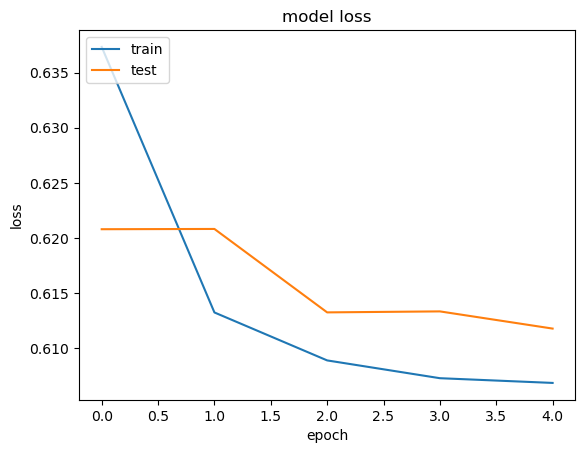

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show();

**Show top 10 movie recommendations to a user**

In [34]:
movie_df = pd.read_csv("movies.csv")

# Let us get a user and see the top recommendations.
# user_id = df.userId.sample(1).iloc[0]

user_id = 1
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

297/297 [==============================] - 1s 2ms/step
Showing recommendations for user: 1
Movies with high ratings from user
--------------------------------
Tommy Boy (1995) : Comedy
Tombstone (1993) : Action|Drama|Western
Three Caballeros, The (1945) : Animation|Children|Musical
Full Metal Jacket (1987) : Drama|War
Newton Boys, The (1998) : Crime|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Lion King, The (1994) : Adventure|Animation|Children|Drama|Musical|IMAX
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Cool Hand Luke (1967) : Drama
This Is Spinal Tap (1984) : Comedy
Seven Samurai (Shichinin no samurai) (1954) : Action|Adventure|Drama
Rosemary's Baby (1968) : Drama|Horror|Thriller
Odd Couple, The (1968) : Comedy
Outlaw Josey Wales, The (1976) : Action|Adventure|Drama|Thriller|Western
Shaun of the Dead (2004) : Comedy|Horror


## 1.7 Conclusion & Recommendation

**Overall Recommendation based on IMDBs weighted ratings**
- Benefits - Can be used as a cold start recommendation baseline, for new users, with lack of historic data
- Limitations -  Unable to provide highly personalized suggestions for new users


**Content Based Filtering**
- Benefits - Improvement over the initial approach, leveraging movie attributes and user profiles to offer more personalized recommendations
- Limitations – Recommendations not customized for individual users


**Collaborative Filtering**
- Benefits: Identifies user preferences by analyzing interactions and behaviors of similar users. 
- Limitations: SVD & NN are resource intensive and need advanced software frameworks & computational resources


**Recommendation:**
As recommendation, while IMDB's weighted recommendation provides a basic entry point, content-based filtering enhances personalization, and collaborative filtering stands out as a more advanced and versatile approach.


## 1.8 Future Scope of Improvement

- Exploring Hybrid Modeling -  Combining Context based and collaborative recommendations
- This can enhance personalization, by considering user preferences beyond their interactions


## 1.9 Literature Review

- Harper and Konstan (2015) documented best practices and limitations of using the MovieLens datasets in new research.
- Cosley et al. (2003) discussed how recommender system interfaces affect users' opinions.
- Isinkaye et al. (2015) explored characteristics and potentials of different prediction techniques in recommendation systems in order to serve as a guide for research and practice in the field of recommendation systems.
- Tam (2021) showed how a recommender system can be built using singular value decomposition.


**References**
- Harper, F. Maxwell, and Konstan, Joseph A. 2015. The MovieLens Datasets: History
and Context. December 22.
    https://dl.acm.org/doi/10.1145/2827872
- Cosley, Dan, Lam, Shyong K., Albert, Istvan, and Konstan, Joseph A. 2003. Is seeing 
believing?: how recommender system interfaces affect users' opinions. April 5.
    https://dl.acm.org/doi/10.1145/642611.642713
- Isinkaye, F.O., Folajimi Y.O., and Ojokoh, B.A. 2015. Recommendation systems: 
Principles, methods and evaluation. November.
    https://www.sciencedirect.com/science/article/pii/S1110866515000341
- Tam, Adrian. 2021. Using Singular Value Decomposition to Build a Recommender System.
October 29.
    https://machinelearningmastery.com/using-singular-value-decomposition-to-build-a-recommender-system/
